In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from sklearn.kernel_ridge import KernelRidge
import pickle
from sklearn.decomposition import PCA

In [81]:
database = "data.sqlite"

conn = sqlite3.connect(database)

train_df = pd.read_sql("select * from new_table_name", con=conn)
train_df.head()

,Unnamed: 0,year,make,model,final_price,mileage,engine,zipcode,car_fax_report,engine string
0,0,1999,Porsche,Porsche 996 911,"$29,840",44000,3400.000,33407,No Carfax,3.4-Liter Flat-Six
1,1,1976,Triumph,Triumph TR6,"$23,500",95000,2500.000,46229,No Carfax,2.5-Liter Inline-Six
2,5,1994,BMW,BMW E31 8-Series,"$19,900",95000,4000.000,92887,Carfax,4.0-Liter V8
3,6,2020,Jeep,Jeep Wrangler,"$65,000",17000,6400.000,48507,Carfax,6.4-Liter V8
4,7,1966,Ford,Ford Mustang 1964.5-1966,"$35,750",31000,4735.843,97005,No Carfax,289ci V8


In [82]:
conn.close()

In [83]:
train_df['final_price']=(train_df['final_price'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [84]:
train_df = train_df.drop(['model', 'engine string', 'Unnamed: 0', 'zipcode'], axis='columns')
train_df

,year,make,final_price,mileage,engine,car_fax_report
0,1999,Porsche,29840.0,44000,3400.000,No Carfax
1,1976,Triumph,23500.0,95000,2500.000,No Carfax
2,1994,BMW,19900.0,95000,4000.000,Carfax
3,2020,Jeep,65000.0,17000,6400.000,Carfax
4,1966,Ford,35750.0,31000,4735.843,No Carfax
...,...,...,...,...,...,...
7103,2013,Mercedes-Benz,120000.0,11000,6000.000,Carfax
7104,2005,Mercedes-Benz,29750.0,40000,5400.000,Carfax
7105,1974,Honda,3500.0,3000,89.000,No Carfax
7106,1987,BMW,15750.0,48000,2500.000,Carfax


In [85]:
train_df.make.value_counts()

Porsche          1103
BMW               804
Chevrolet         776
Mercedes-Benz     720
Ford              699
                 ... 
Geo                 2
Lancia              2
Amphicar            2
Ariel               1
Alpine              1
Name: make, Length: 66, dtype: int64

In [86]:
train_df1 = train_df.apply(lambda x: x.mask(x.map(x.value_counts())<30, 'other') if x.name=='make' else x)
train_df1.make.value_counts()

Porsche                    1103
BMW                         804
Chevrolet                   776
Mercedes-Benz               720
Ford                        699
Toyota                      319
other                       274
Honda                       193
Land Rover                  172
Jaguar                      164
Volkswagen                  163
Jeep                        161
Ferrari                     153
Pontiac                     111
Dodge                       100
Triumph                      84
Mazda                        79
Datsun                       78
Cadillac                     74
Lexus                        70
Audi                         69
MG                           58
Alfa Romeo                   57
Nissan                       52
Lotus                        49
Buick                        46
Acura                        46
Aston Martin                 46
Shelby                       43
Volvo                        42
International Harvester      37
GMC     

In [87]:
#train_df1 = train_df1.query('make != "other"')
#train_df1.make.value_counts()

In [88]:
# Convert categorical data to numeric and separate target feature for training data
train_df2 = pd.get_dummies(train_df1)
train_df2.head()

,year,final_price,mileage,engine,make_Acura,make_Alfa Romeo,make_Aston Martin,make_Audi,make_Austin-Healey,make_BMW,...,make_Porsche,make_Saab,make_Shelby,make_Toyota,make_Triumph,make_Volkswagen,make_Volvo,make_other,car_fax_report_Carfax,car_fax_report_No Carfax
0,1999,29840.0,44000,3400.000,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1976,23500.0,95000,2500.000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1994,19900.0,95000,4000.000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2020,65000.0,17000,6400.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1966,35750.0,31000,4735.843,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [89]:
train_X = train_df2.drop(columns='final_price')
train_y = train_df2['final_price']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=42)

In [91]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [92]:
#pca = PCA(n_components = .7, svd_solver='full')
#X_train_scaled = pca.fit_transform(X_train_scaled)
#X_test_scaled = pca.fit_transform(X_test_scaled)

In [93]:
#X_train_scaled[0]

In [94]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print(f'Model Score: {model.score(X_train_scaled, y_train)}')
print(f'Model Score: {model.score(X_test_scaled, y_test)}')

Model Score: 0.185761495380806
Model Score: 0.10174928717742338


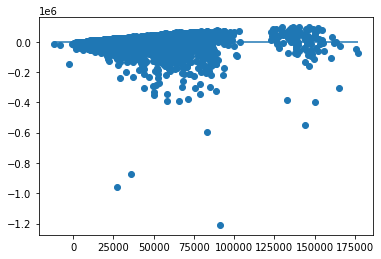

In [95]:
predictions = model.predict(X_train_scaled)
# Plot Residuals
plt.scatter(predictions, predictions - y_train)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [96]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)
print(f"True output: {train_y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y_train[0]}")

x_min = X_train_scaled.min()
x_max = X_train_scaled.max()
y_min_actual = y_train.min()
y_max_actual = y_train.max()

y_min = 101.896225057 + (model.coef_ * x_min)
y_max = 101.896225057 + (model.coef_ * x_max)
print(f"Actual Min Value: {y_min_actual}")
print(f"Calculated Min Value: {y_min}")
print(f"Actual Max Value: {y_max_actual}")
print(f"Calculated Max Value: {y_max}")

# y_min_predicted = model.predict([[x_min]])
# y_max_predicted = model.predict([[x_max]])
# print(f"Actual Min Value: {y_min_actual}")
# print(f"Predicted Min Value: {y_min_predicted}")
# print(f"Actual Max Value: {y_max_actual}")
# print(f"Predicted Max Value: {y_max_predicted}")

# plt.scatter(X, y, c='blue')
# plt.plot([x_min, x_max], [y_min, y_max], c='red')

Weight coefficients:  [ 8460.59653569 -4375.78444026  8855.15794368  3166.55359608
  -106.39570481    43.9581025    310.35576405   987.67603501
 -3186.5745699    320.22822146 -1032.90860948 -2022.58217233
 -3407.83280829 -1548.92720996 -1190.07648423 13417.39497477
  -176.64618309 -2589.03345894 -1430.83863346 -2968.90931313
 -1126.66538229   746.6134501  -3126.78379824 -1063.7629088
 -1912.70006377 -1679.79260286   943.06917748 -1376.8883293
 -1688.57590376 -1688.09262613 -1113.67142855  -524.65338856
 -2070.89359681 -2338.37231811 10225.64529672  -823.49706467
  -748.61321945 -1033.19102516 -2077.63182479 -1136.66974611
  -772.28227898  4722.06309147 -4023.68050518  4023.68050518]
y-axis intercept:  46572.078972050294
True output: 29840.0
Predicted output: 40269.63168595027
Prediction Error: 10429.63168595027
Actual Min Value: 0.0
Calculated Min Value: [-33276.19423658  17364.90224026 -34832.78735778 -12390.54587824
    521.64032288    -71.52387783  -1122.49530859  -3794.60680572
  1

In [97]:
reg = Lasso(max_iter=10000).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.1857614771630982
Test Score: 0.10176779815815817


In [98]:
reg = Ridge(alpha=100).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.18566088517234747
Test Score: 0.10282276587026229


In [99]:
reg = ElasticNet(alpha=10).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.06038603073862969
Test Score: 0.03910520147789209


In [100]:
def test_model(model, data):
    X_train_scaled, X_test_scaled, y_train, y_test = data
    reg = model.fit(X_train_scaled, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train_scaled, y_train)}')
    print(f'Test Score: {reg.score(X_test_scaled, y_test)}')
    plt.show()
    y_pred = reg.predict(X_test_scaled)
    print(mean_absolute_error(y_test, y_pred))    
    print(mean_squared_error(y_test, y_pred)) 
    print(np.median(abs(y_test - y_pred)))
    print('\n')
    return [
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        np.median(abs(y_test - y_pred)),
        y_pred,
        reg]


In [101]:
data = [X_train_scaled, X_test_scaled, y_train, y_test]

In [102]:
test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)
test_model(GradientBoostingRegressor(), data)
test_model(SGDRegressor(), data)
test_model(KernelRidge(), data)
test_model(BayesianRidge(), data)

Model: KNeighborsRegressor
Train score: 0.5712266357161743
Test Score: 0.23814604920967886
20375.924704558245
3015793430.3943048
9570.0


Model: RandomForestRegressor
Train score: 0.9131052146236358
Test Score: 0.37764251421503525
18197.429012978893
2463597668.6082425
8392.5


Model: ExtraTreesRegressor
Train score: 0.9963444970713364
Test Score: 0.38687781550715616
18506.643897955357
2427039794.3127847
8605.0


Model: AdaBoostRegressor
Train score: -1.5751574466868083
Test Score: -1.380114878267574
85087.6983342267
9421667769.809355
84594.13438438438


Model: SVR
Train score: -0.08888541648141612
Test Score: -0.06112089239629026
28065.439412872158
4200439484.2649016
14502.07688586611


Model: GradientBoostingRegressor
Train score: 0.5260495044232764
Test Score: 0.30696855595344585
21793.010117157446
2743360028.315323
12720.980334807988


Model: SGDRegressor
Train score: 0.17831313992339115
Test Score: 0.0969872094240708
27917.505365603047
3574569690.891355
18097.332655231818


Model: 

[27408.03039371994,
 3548716836.0914793,
 17824.101908855395,
 array([ 69765.37783819,  14871.76802256,  69784.84899331, ...,
         78387.94472205, 128448.1178707 ,  47705.11994255]),
 BayesianRidge()]

In [56]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(RandomForestRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)
    

Model: RandomForestRegressor
Train score: 0.4620285302225656
Test Score: 0.2056720707905304
24387.49484891533
3144341442.3507166
15734.849748659806


Model: RandomForestRegressor
Train score: 0.4702694747247492
Test Score: 0.237265345845439
24229.266344678916
3019279688.3801637
16016.64207859605


Model: RandomForestRegressor
Train score: 0.4761923990022455
Test Score: 0.24261246937083913
24262.862311558012
2998113138.0424247
16027.378699741374


Model: RandomForestRegressor
Train score: 0.47526943595605686
Test Score: 0.2556255391240717
24144.754560331072
2946600994.238024
15981.531864169614


Model: RandomForestRegressor
Train score: 0.47415077602828515
Test Score: 0.2617277355534724
24134.247823559563
2922445493.195244
15994.848143176503


Model: RandomForestRegressor
Train score: 0.4745919543977868
Test Score: 0.2600047672234511
24108.654921297486
2929265851.0408196
16061.276863899468


Model: RandomForestRegressor
Train score: 0.47341063620703294
Test Score: 0.2618289171978869
240

Test Score: 0.2875660691422023
23954.07878830941
2820164633.9723
16052.599957006409


Model: RandomForestRegressor
Train score: 0.4758835650338279
Test Score: 0.28777900337518303
23950.579324730097
2819321735.3297677
16097.185449633427


Model: RandomForestRegressor
Train score: 0.4759050625799397
Test Score: 0.288231062968233
23955.435061500146
2817532260.654927
16113.868325550051


Model: RandomForestRegressor
Train score: 0.47622000571642176
Test Score: 0.28782610717025303
23960.837295679637
2819135275.2929435
16091.033962952173


Model: RandomForestRegressor
Train score: 0.4763338137148173
Test Score: 0.2882304602205834
23961.395312480374
2817534646.627198
16075.317071141664


Model: RandomForestRegressor
Train score: 0.47655753024605285
Test Score: 0.2882606023902572
23961.065111677577
2817415329.0635295
16020.851018923364


Model: RandomForestRegressor
Train score: 0.4766846197993958
Test Score: 0.2873535893631187
23966.153020118803
2821005733.662322
16087.84077342477


Model: Ra

Model: RandomForestRegressor
Train score: 0.549467382257983
Test Score: 0.31382939323891657
22634.261287198435
2716201452.854682
14347.693713291668


Model: RandomForestRegressor
Train score: 0.5488494138622774
Test Score: 0.31218483393360386
22619.22521563537
2722711429.1351895
14281.217604752557


Model: RandomForestRegressor
Train score: 0.5481823952608498
Test Score: 0.3131292087091041
22608.222863043935
2718973128.3219833
14333.609442251203


Model: RandomForestRegressor
Train score: 0.5489838567530103
Test Score: 0.3144177989547964
22635.827558463017
2713872253.0250874
14335.216024092959


Model: RandomForestRegressor
Train score: 0.5487523182967371
Test Score: 0.314958881832054
22642.00384028877
2711730380.3146553
14319.98848997744


Model: RandomForestRegressor
Train score: 0.5486559428591489
Test Score: 0.3128211148453206
22662.789864936134
2720192715.6843367
14280.831831534597


Model: RandomForestRegressor
Train score: 0.5480964493537903
Test Score: 0.31497369979644163
22651

22643.62398772067
2719392527.7262626
14308.97438156855


Model: RandomForestRegressor
Train score: 0.5471597963756865
Test Score: 0.3135546355019694
22644.58219023858
2717289079.3967185
14277.950329195697


Model: RandomForestRegressor
Train score: 0.5471388454993109
Test Score: 0.31405187528502687
22639.286187250018
2715320759.261974
14247.855449662879


Model: RandomForestRegressor
Train score: 0.5471592960040845
Test Score: 0.31424822022882004
22637.907900955983
2714543529.202369
14252.920684620767


Model: RandomForestRegressor
Train score: 0.5472251578059821
Test Score: 0.3142972739509873
22633.08281252015
2714349350.3930387
14253.593823927637


Model: RandomForestRegressor
Train score: 0.5472560990950598
Test Score: 0.3136298408429844
22633.88965673325
2716991379.5907016
14237.503917428203


Model: RandomForestRegressor
Train score: 0.5472824965829901
Test Score: 0.3137056302120147
22624.825867764423
2716691367.9139514
14223.28649712403


Model: RandomForestRegressor
Train score:

Model: RandomForestRegressor
Train score: 0.6018118494470075
Test Score: 0.3304512739695834
21640.12217141605
2650403856.5354114
12906.898491824773


Model: RandomForestRegressor
Train score: 0.6013118340950409
Test Score: 0.33172912112829467
21623.205960123818
2645345507.671706
12921.814405125748


Model: RandomForestRegressor
Train score: 0.6018254586807205
Test Score: 0.33242811761459445
21624.70050511022
2642578535.0661764
12869.107476512549


Model: RandomForestRegressor
Train score: 0.6018996128583194
Test Score: 0.3346946653944196
21616.113645291203
2633606421.845551
12873.739487391333


Model: RandomForestRegressor
Train score: 0.6019775525970439
Test Score: 0.3348181323326781
21614.72265131192
2633117678.851064
12904.558031467612


Model: RandomForestRegressor
Train score: 0.6021783502765501
Test Score: 0.33618762168305094
21619.32967119773
2627696565.0252905
12915.323983477538


Model: RandomForestRegressor
Train score: 0.6024001516486479
Test Score: 0.3360417895868064
21614.

Model: RandomForestRegressor
Train score: 0.6039012995878739
Test Score: 0.33252350994241586
21586.640800487105
2642200925.2168665
12855.155848530761


Model: RandomForestRegressor
Train score: 0.6037830228345991
Test Score: 0.3324339299578475
21589.84800387338
2642555526.946865
12868.948379295078


Model: RandomForestRegressor
Train score: 0.6038931339893563
Test Score: 0.33255166431546923
21584.765677928095
2642089476.3319416
12861.289291915731


Model: RandomForestRegressor
Train score: 0.6039377031760367
Test Score: 0.3326791053306627
21586.33491108676
2641585001.9822526
12857.690752035385


Model: RandomForestRegressor
Train score: 0.6038896347686149
Test Score: 0.3323867004089457
21587.002409419074
2642742484.779335
12846.71809175791


Model: RandomForestRegressor
Train score: 0.6040522116591338
Test Score: 0.3320600658752675
21592.61526968173
2644035465.2512283
12851.856114135895


Model: RandomForestRegressor
Train score: 0.6039138909754902
Test Score: 0.3319334414772882
21596.

Model: RandomForestRegressor
Train score: 0.6510255195969972
Test Score: 0.3486849670009847
20887.26628970482
2578225912.7196937
11795.452466318613


Model: RandomForestRegressor
Train score: 0.6509333079373405
Test Score: 0.34861402902920813
20885.859258081346
2578506720.175017
11769.19881731108


Model: RandomForestRegressor
Train score: 0.6512715510261444
Test Score: 0.3483539092365756
20889.355936323976
2579536402.518887
11791.237879583368


Model: RandomForestRegressor
Train score: 0.6513057942748496
Test Score: 0.34764373696115247
20897.089695521645
2582347614.405952
11811.830786481409


Model: RandomForestRegressor
Train score: 0.6521204104258442
Test Score: 0.34834024657189366
20887.4001763662
2579590486.0795836
11759.680585539936


Model: RandomForestRegressor
Train score: 0.6521070147371819
Test Score: 0.3467034629584017
20888.162214319764
2586069682.3394775
11779.978035962584


Model: RandomForestRegressor
Train score: 0.6520024877139232
Test Score: 0.3466988282873046
20885.

Model: RandomForestRegressor
Train score: 0.6522210280561926
Test Score: 0.3435534649400698
20872.517637118857
2598538927.0281553
11771.680522528612


Model: RandomForestRegressor
Train score: 0.6521980678940718
Test Score: 0.3433931680848028
20871.50204434216
2599173460.9864364
11760.06991217966


Model: RandomForestRegressor
Train score: 0.6521368378903554
Test Score: 0.34304370966388686
20876.507173065118
2600556789.6531725
11741.043781126813


Model: RandomForestRegressor
Train score: 0.6521830056921405
Test Score: 0.3433221325242085
20874.313401369145
2599454654.746398
11787.123601433857


Model: RandomForestRegressor
Train score: 0.6523210973421616
Test Score: 0.34284152369859777
20878.98492366296
2601357141.354708
11767.267773565134


Model: RandomForestRegressor
Train score: 0.6523523277070022
Test Score: 0.3429753583743641
20880.40734615518
2600827357.745243
11783.369786825991


Model: RandomForestRegressor
Train score: 0.6522447506891194
Test Score: 0.3430506365347262
20880.1

Model: RandomForestRegressor
Train score: 0.7006385494882839
Test Score: 0.3578726364962804
20284.29393648395
2541856588.552242
11148.333051699192


Model: RandomForestRegressor
Train score: 0.7012007877464801
Test Score: 0.35832506950919973
20279.772270381305
2540065635.697511
11177.869090107724


Model: RandomForestRegressor
Train score: 0.7014463601778251
Test Score: 0.35727418985767867
20282.22439961906
2544225535.302816
11128.232188900867


Model: RandomForestRegressor
Train score: 0.7011868733904227
Test Score: 0.35660517780265966
20291.524326202623
2546873814.7509804
11156.715722515568


Model: RandomForestRegressor
Train score: 0.7011340205449134
Test Score: 0.35610630972770185
20289.80278097487
2548848580.4675994
11168.019190118757


Model: RandomForestRegressor
Train score: 0.7014038700731604
Test Score: 0.35634376569995607
20293.897650327293
2547908612.69505
11162.810017471907


Model: RandomForestRegressor
Train score: 0.7013531912957449
Test Score: 0.35710649654742743
2029

Model: RandomForestRegressor
Train score: 0.700706549705468
Test Score: 0.3569564651950279
20285.87773453985
2545483246.113796
11238.092342327658


Model: RandomForestRegressor
Train score: 0.7007201812579322
Test Score: 0.3563083461799562
20291.334090194
2548048820.6123447
11250.274241644018


Model: RandomForestRegressor
Train score: 0.7006175000688231
Test Score: 0.3561053633859015
20292.782060891437
2548852326.5548663
11243.561888114931


Model: RandomForestRegressor
Train score: 0.7004409035516705
Test Score: 0.35610074175520645
20291.778426303186
2548870621.2470093
11239.568138313814


Model: RandomForestRegressor
Train score: 0.7004476028174114
Test Score: 0.3559656097070738
20291.54880411306
2549405540.4957333
11217.702688113583


Model: RandomForestRegressor
Train score: 0.7004413885807008
Test Score: 0.35524379440137555
20293.866708417478
2552262841.2351003
11200.749899049937


Model: RandomForestRegressor
Train score: 0.7238563860398042
Test Score: 0.2867244095771302
20824.0

Model: RandomForestRegressor
Train score: 0.7518363323885885
Test Score: 0.36867949143574286
19801.532124038746
2499077730.352654
10611.60464145217


Model: RandomForestRegressor
Train score: 0.7520716949941729
Test Score: 0.3686747462243397
19797.541523242766
2499096514.2381487
10647.503787305744


Model: RandomForestRegressor
Train score: 0.7519931422885683
Test Score: 0.36884951813522115
19788.143908395876
2498404680.8754587
10647.431330189633


Model: RandomForestRegressor
Train score: 0.7514030180217623
Test Score: 0.3687376914512842
19796.66258886171
2498847346.0062366
10631.160542201203


Model: RandomForestRegressor
Train score: 0.7514699555712347
Test Score: 0.3693564549902051
19792.513259693977
2496397974.9506564
10647.017964683906


Model: RandomForestRegressor
Train score: 0.7513142919899645
Test Score: 0.3698721640402083
19784.624749001567
2494356544.354436
10632.727875641227


Model: RandomForestRegressor
Train score: 0.751143475838407
Test Score: 0.3696456928456763
19784

Train score: 0.7949359616702522
Test Score: 0.35530739182120774
19639.12927904269
2552011091.302294
10187.97810334694


Model: RandomForestRegressor
Train score: 0.7954898341840613
Test Score: 0.3537700012015982
19646.57312231848
2558096841.10481
10127.125788728452


Model: RandomForestRegressor
Train score: 0.7981505413887505
Test Score: 0.3568297262098218
19652.240903217193
2545984941.4827867
10137.244058057455


Model: RandomForestRegressor
Train score: 0.7992234981620072
Test Score: 0.35541650115507717
19622.026926527236
2551579182.7823777
10059.925324078344


Model: RandomForestRegressor
Train score: 0.7998181063937346
Test Score: 0.3598301687573109
19572.040847789583
2534107711.0587587
10075.396396176842


Model: RandomForestRegressor
Train score: 0.7992484451836439
Test Score: 0.37035666283141677
19534.390276069167
2492438659.3450522
10070.092358183276


Model: RandomForestRegressor
Train score: 0.7979176505304714
Test Score: 0.36906108318036346
19501.288654387903
2497567202.153

Model: RandomForestRegressor
Train score: 0.7951457953367586
Test Score: 0.37023741455096926
19486.17414673548
2492910702.8126836
10184.917699682701


Model: RandomForestRegressor
Train score: 0.7953363364585802
Test Score: 0.36936955396660753
19486.452004866762
2496346122.7459936
10152.745703873923


Model: RandomForestRegressor
Train score: 0.7953286420821969
Test Score: 0.3687641322439258
19484.259561134695
2498742680.3171496
10166.893062572795


Model: RandomForestRegressor
Train score: 0.7953564884510314
Test Score: 0.3687108158318624
19482.28751357367
2498953732.954031
10143.937418669673


Model: RandomForestRegressor
Train score: 0.7954830250048737
Test Score: 0.36777140842370315
19481.431389678033
2502672370.479047
10165.149865226223


Model: RandomForestRegressor
Train score: 0.7954534879708338
Test Score: 0.3681609358415163
19481.83787637617
2501130428.9738793
10160.876337046095


Model: RandomForestRegressor
Train score: 0.7955976578361924
Test Score: 0.3687619447496423
1947

Model: RandomForestRegressor
Train score: 0.8310950939363898
Test Score: 0.37104685381964564
19256.395902387972
2489706543.2408323
9785.223209825763


Model: RandomForestRegressor
Train score: 0.8302788914026127
Test Score: 0.3720943478071369
19260.379600142696
2485560045.762442
9833.18522770136


Model: RandomForestRegressor
Train score: 0.8304529352298399
Test Score: 0.37149653537753835
19251.139506275842
2487926482.0012
9775.693420005307


Model: RandomForestRegressor
Train score: 0.83105540164151
Test Score: 0.3722416733462247
19265.130109711226
2484976858.6667404
9758.78194950812


Model: RandomForestRegressor
Train score: 0.8306001790294681
Test Score: 0.37114986875616285
19269.749654982
2489298759.3493676
9748.887389161078


Model: RandomForestRegressor
Train score: 0.8296741713193048
Test Score: 0.37016439590262673
19271.211792422626
2493199746.611353
9706.889183880015


Model: RandomForestRegressor
Train score: 0.8286974102913001
Test Score: 0.3709916918002072
19259.5609692363

Model: RandomForestRegressor
Train score: 0.8295333939474221
Test Score: 0.3733008437544746
19195.00755984702
2480784140.1600575
9617.869359011216


Model: RandomForestRegressor
Train score: 0.8292827281911753
Test Score: 0.3728452429812047
19196.531030564944
2482587632.571542
9613.044370332824


Model: RandomForestRegressor
Train score: 0.8297243023614693
Test Score: 0.3725081859416831
19201.798597641144
2483921870.4584794
9627.624226434891


Model: RandomForestRegressor
Train score: 0.8295989656861007
Test Score: 0.3723959445302317
19200.9696337086
2484366177.2851644
9592.474958191611


Model: RandomForestRegressor
Train score: 0.8292439018908827
Test Score: 0.372906273918441
19196.8461902927
2482346042.041786
9600.690847287762


Model: RandomForestRegressor
Train score: 0.8291937344895616
Test Score: 0.3734958118714623
19191.59823592912
2480012360.2595425
9582.712088397719


Model: RandomForestRegressor
Train score: 0.8291944319022315
Test Score: 0.3734418279641414
19198.82597346699

Model: RandomForestRegressor
Train score: 0.8541965653207112
Test Score: 0.3806901306193823
19018.058999495202
2451533700.8083024
9404.559798055998


Model: RandomForestRegressor
Train score: 0.8542444737510315
Test Score: 0.3810779375291793
19029.39473760835
2449998569.9218454
9365.934022251058


Model: RandomForestRegressor
Train score: 0.8542494806191481
Test Score: 0.38067587897101696
19034.045964401703
2451590115.8567085
9408.902705848086


Model: RandomForestRegressor
Train score: 0.8542335300941305
Test Score: 0.380096559533353
19037.186597434265
2453883347.718792
9441.37025592121


Model: RandomForestRegressor
Train score: 0.8542657431000776
Test Score: 0.37899704456325456
19032.719904432117
2458235769.885801
9384.587192118226


Model: RandomForestRegressor
Train score: 0.8542628322070682
Test Score: 0.380721738737706
19014.6950707939
2451408580.2973576
9334.571400231522


Model: RandomForestRegressor
Train score: 0.8540886804091041
Test Score: 0.3804171349429668
19018.14181164

Model: RandomForestRegressor
Train score: 0.8550534568883471
Test Score: 0.37906751899897584
18988.950455034304
2457956797.3346467
9360.145112508242


Model: RandomForestRegressor
Train score: 0.8548780648393061
Test Score: 0.37904729450766783
18991.0623442469
2458036855.839241
9392.62921626433


Model: RandomForestRegressor
Train score: 0.8548076196246167
Test Score: 0.37903540462657304
18990.64226148868
2458083921.8487525
9389.448089390891


Model: RandomForestRegressor
Train score: 0.8548762473681055
Test Score: 0.37912217430624395
18994.57317860287
2457740444.6906466
9364.668011377726


Model: RandomForestRegressor
Train score: 0.8548408587803807
Test Score: 0.3791650687762428
18993.994031982722
2457570647.237095
9358.765751233084


Model: RandomForestRegressor
Train score: 0.8547066541026033
Test Score: 0.37958279119353355
18992.385049010765
2455917096.0275917
9361.3428934041


Model: RandomForestRegressor
Train score: 0.8546875922557761
Test Score: 0.3795138654041701
18992.998253

Model: RandomForestRegressor
Train score: 0.8732476688957982
Test Score: 0.3824910009954037
18879.100082863442
2444404968.2692595
9253.95503296307


Model: RandomForestRegressor
Train score: 0.8735077764344238
Test Score: 0.38155383803550524
18882.199204190998
2448114721.161843
9289.63512627787


Model: RandomForestRegressor
Train score: 0.8731623823013506
Test Score: 0.3817296513856797
18880.759203163354
2447418765.26914
9321.137055848005


Model: RandomForestRegressor
Train score: 0.8726231011997319
Test Score: 0.38118333787853864
18877.848406119945
2449581343.3906584
9277.471757526484


Model: RandomForestRegressor
Train score: 0.8724052175523025
Test Score: 0.38017334075766573
18877.766281604625
2453579409.7899804
9323.229252906502


Model: RandomForestRegressor
Train score: 0.8730144155590119
Test Score: 0.38027652693628977
18872.41815381408
2453170948.0378575
9303.76271700186


Model: RandomForestRegressor
Train score: 0.873094638141551
Test Score: 0.37972149707004643
18867.31222

Model: RandomForestRegressor
Train score: 0.8725025703669896
Test Score: 0.38033402615355305
18852.38575885001
2452943337.7964253
9240.053685589904


Model: RandomForestRegressor
Train score: 0.8725289699883141
Test Score: 0.38035147483540455
18858.216141645215
2452874267.313766
9213.77011393504


Model: RandomForestRegressor
Train score: 0.8724429498363007
Test Score: 0.3802752840392326
18853.956654111247
2453175868.0369935
9219.632147124095


Model: RandomForestRegressor
Train score: 0.872641509751588
Test Score: 0.380615856293114
18850.68350724752
2451827715.1990848
9216.529980396124


Model: RandomForestRegressor
Train score: 0.8726542059160509
Test Score: 0.38175784176324623
18848.235562707592
2447307173.8606067
9263.174895100587


Model: RandomForestRegressor
Train score: 0.8727872358099357
Test Score: 0.38121526382229254
18853.705809904663
2449454964.7700157
9252.126527624292


Model: RandomForestRegressor
Train score: 0.8727421626005145
Test Score: 0.3809767408830047
18854.5268

Model: RandomForestRegressor
Train score: 0.8851142782567105
Test Score: 0.3798700105271169
18808.463944487587
2454780140.344151
9117.870824887603


Model: RandomForestRegressor
Train score: 0.8848106863298844
Test Score: 0.38017163710068025
18797.554610482635
2453586153.7040067
9038.208664647536


Model: RandomForestRegressor
Train score: 0.8848613330152095
Test Score: 0.3795309149555761
18801.342482011336
2456122447.745547
9104.533827923302


Model: RandomForestRegressor
Train score: 0.8848854500496866
Test Score: 0.38003112212343104
18797.15328434415
2454142381.2392454
9135.803646239532


Model: RandomForestRegressor
Train score: 0.8846367206039053
Test Score: 0.3810331096300147
18795.23653723693
2450176020.8409595
9095.859840368717


Model: RandomForestRegressor
Train score: 0.884896768791189
Test Score: 0.38098214792359597
18794.27315953674
2450377752.3923416
9066.854490631638


Model: RandomForestRegressor
Train score: 0.8849754274088785
Test Score: 0.3810785869706482
18787.23406

Model: RandomForestRegressor
Train score: 0.8822087969890109
Test Score: 0.34774710348181603
19309.563121611758
2581938438.771152
8995.196428571428


Model: RandomForestRegressor
Train score: 0.8865233497771604
Test Score: 0.3641668382277745
19091.8096698699
2516941035.8905735
8948.151287693116


Model: RandomForestRegressor
Train score: 0.8895815418594888
Test Score: 0.3696196609614567
18947.281712920183
2495356075.990733
9046.279999999999


Model: RandomForestRegressor
Train score: 0.888879900619157
Test Score: 0.3709676733083792
18882.922534176047
2490019978.7299376
9010.285522748789


Model: RandomForestRegressor
Train score: 0.8902559931211762
Test Score: 0.3728951402725599
18854.392634439337
2482390114.4995975
8966.345206360085


Model: RandomForestRegressor
Train score: 0.8918274459380132
Test Score: 0.3675762193894856
18877.403161147784
2503445024.878841
9036.573433449106


Model: RandomForestRegressor
Train score: 0.8920238432495332
Test Score: 0.3706828605389124
18801.0333699

Model: RandomForestRegressor
Train score: 0.89375591447006
Test Score: 0.3830528573804879
18729.13812042598
2442180863.77626
8950.020255129199


Model: RandomForestRegressor
Train score: 0.8933633086281563
Test Score: 0.38348273300628144
18734.845010116842
2440479204.17758
8898.093786219823


Model: RandomForestRegressor
Train score: 0.8933972680287713
Test Score: 0.38356241379645906
18731.13435314124
2440163788.337973
8884.453154636594


Model: RandomForestRegressor
Train score: 0.89346988502358
Test Score: 0.3823143300918742
18741.613295924686
2445104318.7808022
8872.383384699351


Model: RandomForestRegressor
Train score: 0.8934642164586202
Test Score: 0.3821012182935918
18742.023438070042
2445947920.3143153
8868.579444324278


Model: RandomForestRegressor
Train score: 0.8936516161679645
Test Score: 0.38237335389368887
18739.827214402147
2444870673.482297
8871.128571428577


Model: RandomForestRegressor
Train score: 0.8937104518936191
Test Score: 0.3808227167401237
18744.90360712925

Model: RandomForestRegressor
Train score: 0.8980043962866949
Test Score: 0.3803725739005982
18824.745611879975
2452790746.814683
8910.354430139774


Model: RandomForestRegressor
Train score: 0.8976001645608663
Test Score: 0.3810678659542943
18783.892219849724
2450038438.1791935
8848.162425715393


Model: RandomForestRegressor
Train score: 0.8982435199875853
Test Score: 0.37514187734871896
18832.958627576172
2473496421.8081374
8833.944420145446


Model: RandomForestRegressor
Train score: 0.8980714719852183
Test Score: 0.3758274955666956
18848.76263116345
2470782406.982346
8847.797168295212


Model: RandomForestRegressor
Train score: 0.8986396587193073
Test Score: 0.3753353527193942
18825.666201046653
2472730550.933253
8885.81061887449


Model: RandomForestRegressor
Train score: 0.8989790461177996
Test Score: 0.37644859148895704
18824.07808311334
2468323803.2039475
8946.545672819972


Model: RandomForestRegressor
Train score: 0.8987138454362642
Test Score: 0.37663010046136536
18816.95025

Model: RandomForestRegressor
Train score: 0.8991593791805834
Test Score: 0.37979089667312405
18791.15252289104
2455093311.970914
8794.831580511003


Model: RandomForestRegressor
Train score: 0.8992615087935282
Test Score: 0.37901716023734255
18798.498210422407
2458156142.1333957
8786.407423022476


Model: RandomForestRegressor
Train score: 0.8992363481097103
Test Score: 0.3791184851012481
18792.094149007084
2457755048.38231
8721.40240136625


Model: RandomForestRegressor
Train score: 0.8989901160313187
Test Score: 0.3787152537037618
18795.179463513366
2459351236.993272
8749.27531654574


Model: RandomForestRegressor
Train score: 0.8993860980357133
Test Score: 0.37855917815716666
18794.28524536105
2459969060.931283
8774.578359788367


Model: RandomForestRegressor
Train score: 0.8992677480359669
Test Score: 0.37813005187283355
18794.36295244196
2461667754.267137
8770.038930202223


Model: RandomForestRegressor
Train score: 0.8989896985179253
Test Score: 0.37889707444641374
18787.73231346

Model: RandomForestRegressor
Train score: 0.9021163608341162
Test Score: 0.3822922117456502
18786.369616329164
2445191874.0965743
8848.911585730817


Model: RandomForestRegressor
Train score: 0.9024344843248605
Test Score: 0.38257124786026164
18788.284828720847
2444087311.627068
8817.545857654033


Model: RandomForestRegressor
Train score: 0.9027249571014755
Test Score: 0.3834511676988045
18787.483510772494
2440604155.2220926
8839.103127653369


Model: RandomForestRegressor
Train score: 0.9030186160061332
Test Score: 0.38363033756147413
18793.906965047452
2439894912.598617
8819.318631061673


Model: RandomForestRegressor
Train score: 0.902922978992192
Test Score: 0.38325962542008063
18795.84687501344
2441362373.9662747
8776.734091307255


Model: RandomForestRegressor
Train score: 0.9028376355449285
Test Score: 0.3833617987878549
18793.262690823383
2440957921.418676
8812.426040191815


Model: RandomForestRegressor
Train score: 0.9026697409336056
Test Score: 0.3816433218020693
18795.3521

Model: RandomForestRegressor
Train score: 0.9031822560485786
Test Score: 0.38114267558417736
18744.396648145026
2449742304.79287
8842.083565613852


Model: RandomForestRegressor
Train score: 0.9031317024045177
Test Score: 0.38116777362542575
18748.324107688837
2449642954.375596
8832.464303797467


Model: RandomForestRegressor
Train score: 0.9033443071287828
Test Score: 0.38058971559962573
18759.28337153989
2451931192.947813
8852.486830533544


Model: RandomForestRegressor
Train score: 0.903153539142584
Test Score: 0.3806200387873625
18760.09371352452
2451811158.825433
8836.838344599022


Model: RandomForestRegressor
Train score: 0.9030326252285155
Test Score: 0.3804892723126989
18756.94313791009
2452328796.9827166
8828.901171226025


Model: RandomForestRegressor
Train score: 0.9030662845417526
Test Score: 0.3801886674720668
18764.51634700769
2453518739.10034
8835.748023744978


Model: RandomForestRegressor
Train score: 0.902975451110804
Test Score: 0.3803367612570602
18761.939822977383

Model: RandomForestRegressor
Train score: 0.905143437753318
Test Score: 0.3852832353686505
18809.28391215435
2433351928.4179554
8766.85793743765


Model: RandomForestRegressor
Train score: 0.9057482716751709
Test Score: 0.38601996667032357
18797.27801540236
2430435582.814908
8726.216240641705


Model: RandomForestRegressor
Train score: 0.9057274939971244
Test Score: 0.3860598806580937
18792.355539324843
2430277583.5790005
8744.837857142858


Model: RandomForestRegressor
Train score: 0.905613948860763
Test Score: 0.38527713139599506
18805.496183305586
2433376090.9501762
8701.98394619894


Model: RandomForestRegressor
Train score: 0.9058298991004362
Test Score: 0.3844241950375641
18804.670722408162
2436752433.4415846
8711.45527014582


Model: RandomForestRegressor
Train score: 0.9055455237067118
Test Score: 0.3850682471216127
18795.522460266948
2434202957.8604827
8689.838603500477


Model: RandomForestRegressor
Train score: 0.9051246040985361
Test Score: 0.3844571124130901
18794.33323261

Model: RandomForestRegressor
Train score: 0.9046305714951922
Test Score: 0.381221310553608
18790.051715118818
2449431028.827231
8673.497184774656


Model: RandomForestRegressor
Train score: 0.904881445402382
Test Score: 0.38083740281624334
18788.197296803224
2450950724.8674245
8633.559643671724


Model: RandomForestRegressor
Train score: 0.9049215717066365
Test Score: 0.38111394122516096
18790.418774237543
2449856049.5480933
8667.50380074246


Model: RandomForestRegressor
Train score: 0.9048451388997586
Test Score: 0.3806932173823717
18796.33111223003
2451521481.8790245
8656.704683096967


Model: RandomForestRegressor
Train score: 0.9049214354259119
Test Score: 0.3807200612015602
18804.10252423293
2451415220.812226
8663.252251552796


Model: RandomForestRegressor
Train score: 0.9048078702772938
Test Score: 0.3806702393890631
18799.84672025548
2451612440.1016493
8685.330107526883


Model: RandomForestRegressor
Train score: 0.9050195381090393
Test Score: 0.38102814085724535
18795.8150037

Model: RandomForestRegressor
Train score: 0.9074670424625902
Test Score: 0.38038077933567005
18837.513295553395
2452758265.658475
8739.89684721284


Model: RandomForestRegressor
Train score: 0.9076022561778628
Test Score: 0.3801009182919102
18831.567080134068
2453866093.6041317
8785.654810679975


Model: RandomForestRegressor
Train score: 0.9076893485468623
Test Score: 0.3798200807093338
18837.42763949334
2454977787.171728
8757.377688871362


Model: RandomForestRegressor
Train score: 0.9076946732860522
Test Score: 0.3810864927325617
18832.843969800564
2449964704.2102747
8731.941893477328


Model: RandomForestRegressor
Train score: 0.9074495718289222
Test Score: 0.38143374692887033
18825.95680179204
2448590100.950926
8768.900709219844


Model: RandomForestRegressor
Train score: 0.9074723431051249
Test Score: 0.3810494615803103
18826.26157428745
2450111291.762343
8699.84840342532


Model: RandomForestRegressor
Train score: 0.9074310291723355
Test Score: 0.3812322641241068
18825.921973570

Model: RandomForestRegressor
Train score: 0.9074422896643038
Test Score: 0.38224918084386417
18809.544890946538
2445362211.6143827
8780.679081632654


Model: RandomForestRegressor
Train score: 0.9075944241011579
Test Score: 0.38229919633551146
18808.914794827026
2445164225.647425
8772.78507523413


Model: RandomForestRegressor
Train score: 0.9076644040102081
Test Score: 0.3813845592445667
18818.255281933772
2448784810.0484176
8776.975047879707


Model: RandomForestRegressor
Train score: 0.86766535225342
Test Score: 0.26763900723222156
20294.359794520777
2899045766.416175
8981.86847222222


Model: RandomForestRegressor
Train score: 0.8872548917322887
Test Score: 0.3202618939720885
19527.172016088047
2690738444.5812683
9037.5


Model: RandomForestRegressor
Train score: 0.897608805541731
Test Score: 0.3402708052729433
19427.11803217582
2611533311.9073973
8927.398150084826


Model: RandomForestRegressor
Train score: 0.9005028761467178
Test Score: 0.35032117851073186
19240.66740032915
25717

Test Score: 0.3801982314598019
18837.590539880694
2453480880.123104
8833.110873767222


Model: RandomForestRegressor
Train score: 0.9086488264188144
Test Score: 0.38080516889526983
18831.7698082933
2451078322.613694
8917.206566358025


Model: RandomForestRegressor
Train score: 0.9085008186043363
Test Score: 0.381382366232178
18828.025447482505
2448793491.0723166
8848.467053030305


Model: RandomForestRegressor
Train score: 0.9084107000869028
Test Score: 0.3810577040676849
18828.25865129363
2450078663.934859
8861.390522826052


Model: RandomForestRegressor
Train score: 0.9086236616410179
Test Score: 0.381075917661596
18830.929082192073
2450006565.5532675
8860.416173461897


Model: RandomForestRegressor
Train score: 0.9088651551929531
Test Score: 0.3800394839961001
18830.927786831046
2454109280.825925
8864.909025817695


Model: RandomForestRegressor
Train score: 0.9085096973368655
Test Score: 0.38044854471976464
18832.92211237397
2452490016.8688636
8933.150376671885


Model: RandomForest

Model: RandomForestRegressor
Train score: 0.9075674528018779
Test Score: 0.35897361872872646
19014.308639005565
2537498358.2376947
8963.166666666664


Model: RandomForestRegressor
Train score: 0.9082615563959384
Test Score: 0.3725946954096935
18970.014092751873
2483579423.3463764
8913.895842633692


Model: RandomForestRegressor
Train score: 0.9082348408412154
Test Score: 0.3735201897141813
18946.716036698777
2479915860.7430105
8922.699567099568


Model: RandomForestRegressor
Train score: 0.907663697234362
Test Score: 0.3745866231088323
18956.236451027322
2475694391.756461
8768.333333333328


Model: RandomForestRegressor
Train score: 0.9091128668801387
Test Score: 0.3770036833318683
18953.352418511753
2466126476.102893
8892.668452380953


Model: RandomForestRegressor
Train score: 0.908900973167986
Test Score: 0.3775233043116334
18919.077431962516
2464069560.1606116
8873.845685564436


Model: RandomForestRegressor
Train score: 0.9095355240669125
Test Score: 0.3736448918977463
18938.31626

Model: RandomForestRegressor
Train score: 0.9095408286496921
Test Score: 0.3764607330599198
18881.357215571035
2468275740.88189
8868.52101716058


Model: RandomForestRegressor
Train score: 0.9094863740887466
Test Score: 0.37731105283942545
18873.293921622073
2464909756.099495
8885.396123915183


Model: RandomForestRegressor
Train score: 0.9095664967209347
Test Score: 0.3780484581658722
18867.038642829768
2461990742.374189
8856.031481481477


Model: RandomForestRegressor
Train score: 0.90974112893252
Test Score: 0.37894281133651764
18859.350935489743
2458450451.7270284
8847.202985074633


Model: RandomForestRegressor
Train score: 0.9097963744987043
Test Score: 0.3787314273351984
18855.990747445572
2459287213.788586
8849.413400804991


Model: RandomForestRegressor
Train score: 0.909892395648791
Test Score: 0.3779954537438147
18861.506903622285
2462200560.000857
8852.705797101451


Model: RandomForestRegressor
Train score: 0.9098605254737854
Test Score: 0.37802625233829745
18858.926138529

Model: RandomForestRegressor
Train score: 0.9083282073368188
Test Score: 0.382495988397739
18862.06537030393
2444385225.672687
9050.349999999999


Model: RandomForestRegressor
Train score: 0.9074825901917773
Test Score: 0.3823827501322973
18861.39074850566
2444833478.538783
9038.280779369357


Model: RandomForestRegressor
Train score: 0.9074039233548766
Test Score: 0.38396617861089666
18851.07597512733
2438565488.199814
8974.005141928912


Model: RandomForestRegressor
Train score: 0.9076176876411394
Test Score: 0.38613438602761574
18852.248714707184
2429982654.605146
9027.860491953696


Model: RandomForestRegressor
Train score: 0.9078798599897046
Test Score: 0.38595584010740325
18868.027054786126
2430689427.3568554
9057.6497151099


Model: RandomForestRegressor
Train score: 0.9082646050996285
Test Score: 0.38673674051648843
18866.56942905708
2427598238.657147
8946.864031968034


Model: RandomForestRegressor
Train score: 0.9084280325668979
Test Score: 0.3864024851211584
18877.1020391373

Model: RandomForestRegressor
Train score: 0.9092312082378358
Test Score: 0.3808361122971107
18851.09214182185
2450955833.3782067
8784.347895583243


Model: RandomForestRegressor
Train score: 0.9092600798235135
Test Score: 0.38074589360287536
18854.261916667892
2451312963.4358654
8810.838982368274


Model: RandomForestRegressor
Train score: 0.9091720318959857
Test Score: 0.38091044615149017
18848.21188727969
2450661583.3458204
8838.942857142858


Model: RandomForestRegressor
Train score: 0.9091951369797625
Test Score: 0.38093469605374075
18851.98613511734
2450565590.28072
8820.987515262517


Model: RandomForestRegressor
Train score: 0.9091269534731236
Test Score: 0.3810629886795863
18852.115662499335
2450057744.8363385
8821.691350210967


Model: RandomForestRegressor
Train score: 0.9093333150662357
Test Score: 0.38056446868510685
18861.306606593505
2452031132.6788664
8905.681249999994


Model: RandomForestRegressor
Train score: 0.9090922997589003
Test Score: 0.38051697194818734
18865.87

Model: RandomForestRegressor
Train score: 0.9087953465921702
Test Score: 0.3873725436896318
18912.49887469765
2425081416.3310294
9010.297586785979


Model: RandomForestRegressor
Train score: 0.9091545046101495
Test Score: 0.3875383588275829
18911.58362377998
2424425038.2901015
9021.446011961838


Model: RandomForestRegressor
Train score: 0.9094025210051083
Test Score: 0.38698123766862924
18907.800665039398
2426630398.424237
9000.113131313134


Model: RandomForestRegressor
Train score: 0.9101069780909501
Test Score: 0.38764159105321117
18899.140754394524
2424016394.2612405
8982.51850490196


Model: RandomForestRegressor
Train score: 0.9100651494845569
Test Score: 0.38691691804926054
18897.094927914033
2426885007.1787577
9043.86178141346


Model: RandomForestRegressor
Train score: 0.9099821596523567
Test Score: 0.38676933049904516
18903.714613270764
2427469231.4436393
9080.47337268755


Model: RandomForestRegressor
Train score: 0.910232270110156
Test Score: 0.3857967572506017
18904.55859

Model: RandomForestRegressor
Train score: 0.9092510366799847
Test Score: 0.38173622478951363
18872.793294157866
2447392744.4969473
8951.141860465119


Model: RandomForestRegressor
Train score: 0.9093408544956789
Test Score: 0.38153939011297455
18873.59935916625
2448171913.1601334
8880.792892252597


Model: RandomForestRegressor
Train score: 0.9092587984924476
Test Score: 0.3814495385168364
18873.093294200087
2448527590.062593
8889.060171920282


Model: RandomForestRegressor
Train score: 0.9095546132718318
Test Score: 0.3811566972969336
18872.610816763154
2449686799.9429326
8950.349438202247


Model: RandomForestRegressor
Train score: 0.9095824631711595
Test Score: 0.38106985625009027
18878.388199604055
2450030559.6074805
8927.02873116549


Model: RandomForestRegressor
Train score: 0.9095619439002726
Test Score: 0.3806634470543391
18880.980558202846
2451639327.510209
8926.67220418678


Model: RandomForestRegressor
Train score: 0.909664439129697
Test Score: 0.38072269359966027
18887.5416

18874.68036613039
2439599290.1980433
9019.528898121296


Model: RandomForestRegressor
Train score: 0.9109350624173631
Test Score: 0.38290972876749285
18878.114605885734
2442747437.369958
8967.833809523807


Model: RandomForestRegressor
Train score: 0.910761541029582
Test Score: 0.38271150480743643
18882.646398791443
2443532105.5020385
8975.564345252078


Model: RandomForestRegressor
Train score: 0.9108148327565472
Test Score: 0.3824388197684866
18877.31850616205
2444611527.2838364
9002.116994348245


Model: RandomForestRegressor
Train score: 0.910856921764238
Test Score: 0.3823649849945475
18886.24030666025
2444903801.7098584
9050.27798276021


Model: RandomForestRegressor
Train score: 0.9108405364394232
Test Score: 0.38328744208532184
18883.850004886113
2441252261.895315
9014.762648221345


Model: RandomForestRegressor
Train score: 0.9105603353452647
Test Score: 0.383530664414945
18875.138924856634
2440289468.038249
9048.06597640162


Model: RandomForestRegressor
Train score: 0.910593

18900.077744122922
2448533061.4090405
8969.70011160714


Model: RandomForestRegressor
Train score: 0.9103164954367416
Test Score: 0.3815574320824492
18899.411121745223
2448100494.1526494
8970.202867548724


Model: RandomForestRegressor
Train score: 0.9101545163075059
Test Score: 0.38172839234155054
18897.110575481915
2447423749.186345
8992.708661321667


Model: RandomForestRegressor
Train score: 0.9103159183224998
Test Score: 0.3814740608005146
18896.556417309275
2448430518.777554
8987.868013468018


Model: RandomForestRegressor
Train score: 0.9103433142749011
Test Score: 0.3806683041592064
18904.478719021092
2451620100.6952343
8950.115999999995


Model: RandomForestRegressor
Train score: 0.8657437689303311
Test Score: 0.24742664865463426
20594.481526804266
2979056243.6839347
9016.0


Model: RandomForestRegressor
Train score: 0.888557209427652
Test Score: 0.32612852779732127
19645.523580456964
2667515416.4269714
9250.0


Model: RandomForestRegressor
Train score: 0.8994752207124097
Test

Model: RandomForestRegressor
Train score: 0.9103193201745214
Test Score: 0.3822718424224756
18876.437379060648
2445272505.9170794
8873.994230769225


Model: RandomForestRegressor
Train score: 0.9097805335038426
Test Score: 0.3822752769294048
18886.350688281418
2445258910.4458966
8814.672505802635


Model: RandomForestRegressor
Train score: 0.9099009479554306
Test Score: 0.3830965929887652
18882.300178587546
2442007736.6828322
8828.708671071734


Model: RandomForestRegressor
Train score: 0.9097883416823215
Test Score: 0.3837422060764063
18875.511609413785
2439452081.880143
8870.78484848485


Model: RandomForestRegressor
Train score: 0.9097012692482758
Test Score: 0.3839254131921386
18874.06802071377
2438726857.8192143
8862.898350568084


Model: RandomForestRegressor
Train score: 0.9099013807514749
Test Score: 0.38376418263848
18878.516175202316
2439365087.8159194
8911.696271468143


Model: RandomForestRegressor
Train score: 0.9102165530834682
Test Score: 0.38273359410571506
18879.723831

Train score: 0.907529578283347
Test Score: 0.359926288788468
19101.02413538572
2533727220.600985
9067.097619047614


Model: RandomForestRegressor
Train score: 0.9084219863466707
Test Score: 0.3580035831382199
19085.546513676323
2541338237.204082
9033.449999999997


Model: RandomForestRegressor
Train score: 0.9083567328438207
Test Score: 0.3627497931376994
19005.47116307479
2522550398.772774
8941.637238868188


Model: RandomForestRegressor
Train score: 0.9090247200155612
Test Score: 0.3767414040348521
18976.562932136792
2467164706.829464
9095.559999999998


Model: RandomForestRegressor
Train score: 0.9091209539736488
Test Score: 0.3765150225159145
18948.015361566017
2468060836.457546
9055.703030303033


Model: RandomForestRegressor
Train score: 0.9086461296437162
Test Score: 0.37761006896113225
18928.62266423503
2463726102.9144063
8945.808329055359


Model: RandomForestRegressor
Train score: 0.9100742639221634
Test Score: 0.38058635942644614
18926.899646449543
2451944478.3354073
9078.20

Test Score: 0.3790009019304148
18884.50044487236
2458220500.525409
9076.646774193548


Model: RandomForestRegressor
Train score: 0.9107793227667587
Test Score: 0.3793050452805967
18887.612043312864
2457016551.242971
9024.568253968253


Model: RandomForestRegressor
Train score: 0.910835295115115
Test Score: 0.37786510947627483
18891.89491698984
2462716526.854253
8970.145648998296


Model: RandomForestRegressor
Train score: 0.9108502198826086
Test Score: 0.37842990062072246
18889.0865482884
2460480805.137245
9019.35692307692


Model: RandomForestRegressor
Train score: 0.910911941738338
Test Score: 0.379072077512686
18880.320659101948
2457938752.490638
9005.45757575758


Model: RandomForestRegressor
Train score: 0.9109942790780287
Test Score: 0.37984226714374003
18871.914920288924
2454889962.3293724
9053.27462686567


Model: RandomForestRegressor
Train score: 0.9110568352636935
Test Score: 0.37937324610177536
18870.79487252992
2456746578.7787676
9135.222128851536


Model: RandomForestRegr

Model: RandomForestRegressor
Train score: 0.9099631000287826
Test Score: 0.3763503960948341
18978.105108355154
2468712508.9712195
9072.116666666669


Model: RandomForestRegressor
Train score: 0.9097031135403263
Test Score: 0.37704988219149715
18965.874709851305
2465943598.2465587
9031.902939166099


Model: RandomForestRegressor
Train score: 0.9089967733579305
Test Score: 0.376758289861719
18965.755552363666
2467097864.404247
9119.489450181645


Model: RandomForestRegressor
Train score: 0.9080556754712418
Test Score: 0.3782812111558861
18953.178208928246
2461069391.323294
9069.222554079406


Model: RandomForestRegressor
Train score: 0.9079405895820808
Test Score: 0.37978264344394497
18943.990708584886
2455125982.319754
9132.331818181818


Model: RandomForestRegressor
Train score: 0.9081790324501299
Test Score: 0.38266895136975054
18930.32517143155
2443700552.9816117
8975.097826086956


Model: RandomForestRegressor
Train score: 0.9086254343130589
Test Score: 0.38384968921458407
18925.729

Test Score: 0.37901276079088564
18894.059548316534
2458173557.310817
8900.18158512724


Model: RandomForestRegressor
Train score: 0.9101945382483542
Test Score: 0.3797760302312727
18889.639851828324
2455152160.6749496
8878.771772888867


Model: RandomForestRegressor
Train score: 0.9100790625341666
Test Score: 0.3804844037902534
18883.809006085226
2452348068.994093
8859.500545553277


Model: RandomForestRegressor
Train score: 0.9101104449004819
Test Score: 0.3806095430192763
18886.851989644554
2451852706.248543
8884.142921745584


Model: RandomForestRegressor
Train score: 0.9100344372082884
Test Score: 0.3806671101752499
18879.910849781805
2451624827.0722103
8876.12857142857


Model: RandomForestRegressor
Train score: 0.9100109951210364
Test Score: 0.38087627718919437
18882.212170635226
2450796840.9393635
8880.222508182313


Model: RandomForestRegressor
Train score: 0.9099791368454336
Test Score: 0.3809119443116784
18884.626858346666
2450655652.8894005
8797.962447257378


Model: RandomF

Model: RandomForestRegressor
Train score: 0.9089764004099362
Test Score: 0.38162245761969205
18937.707898232136
2447843091.0272584
9060.42617152962


Model: RandomForestRegressor
Train score: 0.9089645693636611
Test Score: 0.38369183386066186
18926.15159962425
2439651479.9368954
8999.139502096532


Model: RandomForestRegressor
Train score: 0.9090151586476609
Test Score: 0.3838150621599903
18925.967355261044
2439163681.5929112
9027.563776881718


Model: RandomForestRegressor
Train score: 0.9094456938953028
Test Score: 0.3834811913725529
18928.096126998582
2440485306.7236986
9028.925000000003


Model: RandomForestRegressor
Train score: 0.9095370730288115
Test Score: 0.3821985133989694
18933.83605120301
2445562778.3336205
9045.663636363635


Model: RandomForestRegressor
Train score: 0.9101546395630439
Test Score: 0.3827391883403828
18925.568586066143
2443422520.4343185
8982.791176470593


Model: RandomForestRegressor
Train score: 0.9100720927410335
Test Score: 0.38353351799063795
18909.96

Model: RandomForestRegressor
Train score: 0.9099006342541512
Test Score: 0.37940509523260746
18919.68890643653
2456620504.2215276
9057.47015306123


Model: RandomForestRegressor
Train score: 0.9098042869477367
Test Score: 0.3795744564784075
18920.05961357538
2455950088.937972
9064.212941176469


Model: RandomForestRegressor
Train score: 0.9097747172593649
Test Score: 0.37976219455997473
18920.704254025335
2455206929.081102
9025.305710867484


Model: RandomForestRegressor
Train score: 0.9098407070925335
Test Score: 0.37970859059758477
18920.178224590283
2455419119.9839005
9032.528352490423


Model: RandomForestRegressor
Train score: 0.9097798098612909
Test Score: 0.37981441488315704
18919.380206017868
2455000215.3042383
8973.694696969687


Model: RandomForestRegressor
Train score: 0.9100265351052532
Test Score: 0.3795263107944332
18919.719134912004
2456140673.284592
9005.50898876405


Model: RandomForestRegressor
Train score: 0.9100694542198889
Test Score: 0.3795563376255121
18922.41557

In [103]:
mse_list = []
mae_list = []
median_list = []
for i in range(10,25):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(ExtraTreesRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)

Model: ExtraTreesRegressor
Train score: 0.709160915002167
Test Score: 0.2927506119672052
21167.319922023245
2799641658.177501
12217.980259269112


Model: ExtraTreesRegressor
Train score: 0.7195498181120917
Test Score: 0.3211415600883324
20891.162999676693
2687256292.5342035
12449.443947682601


Model: ExtraTreesRegressor
Train score: 0.7224693267100641
Test Score: 0.3260166373054675
20744.76108218767
2667958334.140932
12078.01813196062


Model: ExtraTreesRegressor
Train score: 0.7191356859089602
Test Score: 0.31688726527557987
20826.985220290935
2704096888.207364
12114.662785471068


Model: ExtraTreesRegressor
Train score: 0.7208735224545327
Test Score: 0.31817256224686896
20818.309312889844
2699009049.3137045
12186.153119083036


Model: ExtraTreesRegressor
Train score: 0.7230246706025145
Test Score: 0.3231749092164927
20761.124215658336
2679207294.51294
12194.597607506053


Model: ExtraTreesRegressor
Train score: 0.7239335230190226
Test Score: 0.3248974699568701
20763.38347237972
2672

Test Score: 0.314854614031562
20680.554141751752
2712143123.659228
12156.090040830219


Model: ExtraTreesRegressor
Train score: 0.7277379612517849
Test Score: 0.3151146643223923
20684.210511994752
2711113716.437746
12190.198059711787


Model: ExtraTreesRegressor
Train score: 0.727755629471373
Test Score: 0.31551597354574623
20681.18842948505
2709525136.7393775
12181.30888891059


Model: ExtraTreesRegressor
Train score: 0.7281101493396789
Test Score: 0.31633071433944837
20675.81386411757
2706299991.1185246
12162.659264118894


Model: ExtraTreesRegressor
Train score: 0.7277338857029438
Test Score: 0.3151960258365083
20680.128879570875
2710791647.4644175
12172.0458522365


Model: ExtraTreesRegressor
Train score: 0.7278138244335475
Test Score: 0.314805442557629
20677.74338445739
2712337768.588084
12144.84949993548


Model: ExtraTreesRegressor
Train score: 0.7273273214939633
Test Score: 0.313818438884061
20685.60686545234
2716244815.590247
12170.066324669417


Model: ExtraTreesRegressor
Tra

Train score: 0.7761141532165376
Test Score: 0.3364987742549691
19977.733588092575
2626464869.788602
11515.590079109188


Model: ExtraTreesRegressor
Train score: 0.7750732734395261
Test Score: 0.3313587624518023
20013.713889929575
2646811569.8510733
11507.556573436214


Model: ExtraTreesRegressor
Train score: 0.7760494175285491
Test Score: 0.3330790519242828
20005.205919202846
2640001816.2439666
11548.129921860906


Model: ExtraTreesRegressor
Train score: 0.776798094704359
Test Score: 0.33540713700851144
20000.66508853527
2630786108.0427656
11559.081957354821


Model: ExtraTreesRegressor
Train score: 0.7760349245564581
Test Score: 0.33650398534392223
19997.119007398316
2626444241.7301483
11632.95722426345


Model: ExtraTreesRegressor
Train score: 0.7761539143577295
Test Score: 0.3371998279992403
19989.798136254896
2623689753.542065
11553.095144209172


Model: ExtraTreesRegressor
Train score: 0.7775676281853683
Test Score: 0.33893399449653816
19958.266260915352
2616825067.8311944
11496.7

Model: ExtraTreesRegressor
Train score: 0.7788443246052315
Test Score: 0.33444851043222334
20038.713974942315
2634580824.5077415
11510.842077959147


Model: ExtraTreesRegressor
Train score: 0.7788976527539619
Test Score: 0.3344430195624647
20032.096215235615
2634602560.076518
11478.792525733425


Model: ExtraTreesRegressor
Train score: 0.778860438179418
Test Score: 0.3342956082014975
20032.16093955714
2635186086.8975177
11473.285244602295


Model: ExtraTreesRegressor
Train score: 0.7788722199320138
Test Score: 0.33481394735051595
20028.95706018814
2633134245.0731044
11475.51461690785


Model: ExtraTreesRegressor
Train score: 0.7786133140625597
Test Score: 0.334158725797956
20034.095774422924
2635727934.915643
11474.212765735836


Model: ExtraTreesRegressor
Train score: 0.7786724578255523
Test Score: 0.3351972022329871
20027.140081575264
2631617133.3543506
11446.804123723196


Model: ExtraTreesRegressor
Train score: 0.7786452017119778
Test Score: 0.33494971339955637
20030.359704060553
2

Model: ExtraTreesRegressor
Train score: 0.8224364259472284
Test Score: 0.35175729812880485
19546.9459948929
2566064111.863159
10860.379159780816


Model: ExtraTreesRegressor
Train score: 0.8225646262913904
Test Score: 0.3506496312036699
19541.310142636103
2570448803.4860373
10905.820695733513


Model: ExtraTreesRegressor
Train score: 0.8224695318617288
Test Score: 0.3495061514361637
19551.948485190755
2574975259.990012
10940.326757237937


Model: ExtraTreesRegressor
Train score: 0.8225361391186767
Test Score: 0.3512383968990882
19526.627592059005
2568118178.680008
10915.418503058878


Model: ExtraTreesRegressor
Train score: 0.8223588036075963
Test Score: 0.35212272677418666
19522.6356304998
2564617565.17678
10866.271544548581


Model: ExtraTreesRegressor
Train score: 0.8222786958647144
Test Score: 0.3539173698464323
19520.373354339103
2557513483.3753185
10869.812312985352


Model: ExtraTreesRegressor
Train score: 0.8222486552646517
Test Score: 0.3543984660806202
19500.909192901272
2555

KeyboardInterrupt: 

In [64]:
val1, val2, val3, ypred1, model = test_model(ExtraTreesRegressor(max_depth = 22, n_estimators = 30, n_jobs = -1, random_state=12), data)
y_train_pred1 = model.predict(X_train_scaled)
y_train_pred1

Model: ExtraTreesRegressor
Train score: 0.9887007902864509
Test Score: 0.41318589871362843
18907.581892403472
2322899434.578427
8312.581250000003




array([28438.71657455, 27840.81543969, 54000.        , ...,
       12210.90179627, 23047.25300796, 46973.51537037])

In [ ]:
18872.614532432657
2431550855.51728
8486.692576381844

In [ ]:
16951.671624611543
1149996994.0746589
8577.387154818865

In [60]:
val1, val2, val3, ypred2, model2 = test_model(RandomForestRegressor(max_depth = 16, n_estimators = 510, n_jobs = -1, random_state=12), data)
y_train_pred2 = model2.predict(X_train_scaled)
y_train_pred2

Model: RandomForestRegressor
Train score: 0.8939101633148303
Test Score: 0.38438443300908287
18707.630570281402
2436909831.147731
8843.097284666419




array([28997.74083406, 26776.17207434, 55171.73333333, ...,
       16621.38478276, 22479.34573964, 53518.52543801])

In [ ]:
19716.06561061078
2966289197.249835
8733.248887866965

In [66]:
ypred = (ypred1 + ypred2)/2
print(mean_absolute_error(y_test, ypred))    
print(mean_squared_error(y_test, ypred)) 
print(np.median(abs(y_test - ypred)))

18535.649860984235
2323558899.7031913
8469.00921275084


In [67]:
ypred_geo = (ypred1 * ypred2) ** (1/2)
print(mean_absolute_error(y_test, ypred_geo))    
print(mean_squared_error(y_test, ypred_geo)) 
print(np.median(abs(y_test - ypred_geo)))

18480.242889749647
2350217048.611171
8412.057767528422


In [297]:
y_train_pred = [y_train_pred1, y_train_pred2]

In [33]:
filename='Regressor_model.h5'
pickle.dump(model, open(filename, 'wb'))

In [264]:
filename='Regressor_model2.h5'
pickle.dump(model2, open(filename, 'wb'))

In [185]:
model2 = pickle.load(open(filename, 'rb'))
model2

ExtraTreesRegressor(max_depth=21, n_estimators=37, n_jobs=-1, random_state=12)

In [65]:
print(min(mae_list))
print(min(mse_list))
print(min(median_list))

18523.633539414182
2245574803.4544806
8312.581250000003


In [63]:
print(mae_list.index(18523.633539414182))
print(mse_list.index(2245574803.4544806))
print(median_list.index(8312.581250000003))

1423
2200
1702


In [59]:
print(mae_list[])
print(mse_list[1151])
print(median_list[1151])

18703.835887046585
2437451352.486947
8849.056860993667


AttributeError: 'list' object has no attribute 'shape'

In [317]:
X_test_price1 = pd.DataFrame(data=ypred1)
X_train_price1 = pd.DataFrame(data=y_train_pred1)
X_test_price1

,0
0,29624.714500
1,23580.253205
2,19688.299360
3,27549.826223
4,27178.731188
...,...
1385,66308.581725
1386,89865.783784
1387,58669.027027
1388,26093.942321


In [318]:
X_test_price2 = pd.DataFrame(data=ypred2)
X_train_price2 = pd.DataFrame(data=y_train_pred2)

In [319]:
X_test_price3 = pd.concat([X_test_price1, X_test_price2], axis=1)
X_train_price3 = pd.concat([X_train_price1, X_train_price2], axis=1)

In [320]:
X_test_scaled_df = pd.DataFrame(data=X_test_scaled)
X_train_scaled_df = pd.DataFrame(data=X_train_scaled)

In [321]:
X_test_price = pd.concat([X_test_price3, X_test_scaled_df], axis=1)
X_train_price = pd.concat([X_train_price3, X_train_scaled_df], axis=1)

X_train_price.shape

(4168, 18)

In [337]:
data2 = [X_train_price, X_test_price, y_train, y_test]

In [338]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(RandomForestRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data2)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)

Model: RandomForestRegressor
Train score: 0.9869005422480864
Test Score: 0.5681275603331808
17441.072024456553
1132276326.9546764
7849.58623079961


Model: RandomForestRegressor
Train score: 0.9881963929526026
Test Score: 0.5691954549060614
17434.934448286713
1129476537.8653595
7771.6068305517


Model: RandomForestRegressor
Train score: 0.9875213627443427
Test Score: 0.5656383262981348
17471.781766008327
1138802561.3499694
7774.167934742105


Model: RandomForestRegressor
Train score: 0.9879446019468496
Test Score: 0.5654468527165531
17480.71261796157
1139304563.7556548
7806.698541310932


Model: RandomForestRegressor
Train score: 0.9879338360019947
Test Score: 0.5659764074038047
17474.001540121924
1137916185.6580265
7818.676837692992


Model: RandomForestRegressor
Train score: 0.9881491811370824
Test Score: 0.5665274482489747
17468.937583419407
1136471475.4916346
7792.343874083046


Model: RandomForestRegressor
Train score: 0.9881184744169275
Test Score: 0.5670004522823816
17461.143817

17450.627417643027
1134271169.5761502
7706.826279643061


Model: RandomForestRegressor
Train score: 0.9874923921279322
Test Score: 0.5672647578625811
17451.971042795274
1134538408.8162832
7716.015101616802


Model: RandomForestRegressor
Train score: 0.9874827674762403
Test Score: 0.5672661999668007
17451.913564926792
1134534627.9302647
7726.851733570618


Model: RandomForestRegressor
Train score: 0.9875226458360233
Test Score: 0.5671891507365094
17452.863617679617
1134736634.3827634
7721.834267835033


Model: RandomForestRegressor
Train score: 0.9875250477677929
Test Score: 0.5672170096760139
17452.867434093223
1134663594.2561014
7718.87822722141


Model: RandomForestRegressor
Train score: 0.9875115002351919
Test Score: 0.567176279378155
17453.492062470697
1134770380.3063788
7724.7590082568295


Model: RandomForestRegressor
Train score: 0.9875180194932527
Test Score: 0.5671132459873087
17454.372641400365
1134935640.252852
7729.547124735413


Model: RandomForestRegressor
Train score: 0.

Model: RandomForestRegressor
Train score: 0.9882499298225883
Test Score: 0.5664936738978533
17482.35494897055
1136560024.5508487
7864.410993860121


Model: RandomForestRegressor
Train score: 0.988239740161216
Test Score: 0.5664978931039828
17480.04958255849
1136548962.7029972
7769.709006712434


Model: RandomForestRegressor
Train score: 0.988239274706152
Test Score: 0.566407427025065
17479.600541706153
1136786145.2368724
7808.243383796806


Model: RandomForestRegressor
Train score: 0.9882333091692627
Test Score: 0.5665462758355783
17481.21798407479
1136422113.6230667
7798.116714274325


Model: RandomForestRegressor
Train score: 0.9881790807427513
Test Score: 0.5668028632277466
17480.56871999269
1135749396.8593588
7833.202321208661


Model: RandomForestRegressor
Train score: 0.9881798077775092
Test Score: 0.5668072991501536
17479.7940012448
1135737766.8282006
7815.29347119152


Model: RandomForestRegressor
Train score: 0.9882074390602071
Test Score: 0.5668821285616025
17478.99775281123


Model: RandomForestRegressor
Train score: 0.988106006203682
Test Score: 0.5656190216772037
17490.38095596562
1138853173.8995867
7778.6267614390235


Model: RandomForestRegressor
Train score: 0.9880945266223162
Test Score: 0.5655788796550074
17490.08910754024
1138958417.6180422
7747.719974109312


Model: RandomForestRegressor
Train score: 0.9881030388023152
Test Score: 0.5656083663199973
17489.789994574905
1138881109.9464653
7745.323254807034


Model: RandomForestRegressor
Train score: 0.9881019177559742
Test Score: 0.5657083803408511
17488.645081921833
1138618894.76954
7751.092036082024


Model: RandomForestRegressor
Train score: 0.9880858267607889
Test Score: 0.56575394864109
17487.662216173285
1138499424.521196
7750.893994318321


Model: RandomForestRegressor
Train score: 0.9881017313532394
Test Score: 0.5657669004784442
17487.568557426614
1138465467.5990126
7762.626560206665


Model: RandomForestRegressor
Train score: 0.988120408548475
Test Score: 0.5657928210128086
17487.1549808170

Model: RandomForestRegressor
Train score: 0.9887671129558803
Test Score: 0.5644165560228136
17585.58636919708
1142005779.3205125
7916.603420184298


Model: RandomForestRegressor
Train score: 0.9886368237009118
Test Score: 0.5642970086437218
17586.50707964135
1142319206.7469058
7902.026261302359


Model: RandomForestRegressor
Train score: 0.9886618346220721
Test Score: 0.5642398494305063
17587.20830357131
1142469065.86744
7919.687427440145


Model: RandomForestRegressor
Train score: 0.9886398228417718
Test Score: 0.5643656433723226
17586.41428795438
1142139261.301761
7909.617686962702


Model: RandomForestRegressor
Train score: 0.9885895941625203
Test Score: 0.5641667534222381
17588.70895437747
1142660707.8250067
7916.847474919197


Model: RandomForestRegressor
Train score: 0.988667524475187
Test Score: 0.5641593544931969
17590.186436180637
1142680106.2200625
7929.587001346486


Model: RandomForestRegressor
Train score: 0.98858024128808
Test Score: 0.5641423064542608
17588.38865569579
1

Test Score: 0.5632103378637263
17594.12385965932
1145168222.998861
7942.817962287039


Model: RandomForestRegressor
Train score: 0.9886123727103107
Test Score: 0.5632459144020201
17593.876057826164
1145074948.9938421
7938.74375962277


Model: RandomForestRegressor
Train score: 0.9886303377125957
Test Score: 0.563151816472601
17593.982186922396
1145321653.4558794
7919.725133631184


Model: RandomForestRegressor
Train score: 0.988655416951782
Test Score: 0.56316854735658
17593.74284982857
1145277788.6890674
7923.184799610361


Model: RandomForestRegressor
Train score: 0.9886738471821422
Test Score: 0.5631925325007757
17593.4301883764
1145214904.8176346
7920.459145135447


Model: RandomForestRegressor
Train score: 0.9886747597250717
Test Score: 0.5632269513172943
17593.15564995149
1145124666.1092422
7919.271126461659


Model: RandomForestRegressor
Train score: 0.9886932359156423
Test Score: 0.563248772581454
17593.3758479265
1145067455.4642396
7917.753178359069


Model: RandomForestRegres

Model: RandomForestRegressor
Train score: 0.9890597186436322
Test Score: 0.5622656525085323
17644.69737412551
1147644984.1113143
8011.162259947938


Model: RandomForestRegressor
Train score: 0.9890294132220254
Test Score: 0.5623477842959548
17642.479146282352
1147429652.2909722
7979.067991760694


Model: RandomForestRegressor
Train score: 0.9890380452782005
Test Score: 0.5621478532375295
17643.745744338834
1147953828.3755877
7980.895840546025


Model: RandomForestRegressor
Train score: 0.9890553796833375
Test Score: 0.5620856024032018
17643.74446551478
1148117036.6277673
7982.170699423328


Model: RandomForestRegressor
Train score: 0.9890876317372311
Test Score: 0.5621760923086547
17642.56650813969
1147879791.6258593
8000.147277411856


Model: RandomForestRegressor
Train score: 0.9890611145116439
Test Score: 0.5621618005241004
17642.645263653758
1147917261.6004038
7997.905106131595


Model: RandomForestRegressor
Train score: 0.9890579877379905
Test Score: 0.5622103975205632
17642.04381

Model: RandomForestRegressor
Train score: 0.9890724830383023
Test Score: 0.562895136917025
17633.904573126136
1145994611.8521507
7942.124061869792


Model: RandomForestRegressor
Train score: 0.9890793108344926
Test Score: 0.562825812056684
17635.30136390776
1146176366.673769
7943.882300522724


Model: RandomForestRegressor
Train score: 0.9890687461507504
Test Score: 0.5628317177431947
17635.157978499938
1146160883.2383463
7946.674168530204


Model: RandomForestRegressor
Train score: 0.9890761412686822
Test Score: 0.562790147946018
17636.08028352933
1146269870.2746477
7957.866796471899


Model: RandomForestRegressor
Train score: 0.9890943681828439
Test Score: 0.5628261550871201
17635.19475658044
1146175467.3220012
7959.117355001079


Model: RandomForestRegressor
Train score: 0.9890954112931328
Test Score: 0.5628442327034948
17634.9509761485
1146128071.7135093
7952.870439642626


Model: RandomForestRegressor
Train score: 0.9891168928565541
Test Score: 0.5628917897695016
17634.70018624208

Model: RandomForestRegressor
Train score: 0.9892172732153877
Test Score: 0.5615897321803945
17668.73853340147
1149417101.329649
7977.608550310415


Model: RandomForestRegressor
Train score: 0.9892438618297927
Test Score: 0.561653433958132
17668.45032362506
1149250089.0170023
7971.169376048674


Model: RandomForestRegressor
Train score: 0.9892508367293182
Test Score: 0.5617132978607651
17667.697780367827
1149093138.7845616
7975.374360994076


Model: RandomForestRegressor
Train score: 0.9892409632386673
Test Score: 0.5616201947498436
17668.288199557937
1149337235.0472069
7970.4876397500675


Model: RandomForestRegressor
Train score: 0.989210609264746
Test Score: 0.5616662883881496
17669.314460116362
1149216387.475833
7972.030519562044


Model: RandomForestRegressor
Train score: 0.989217099899955
Test Score: 0.5617249930858617
17669.26691028862
1149062476.4285066
7966.066928110737


Model: RandomForestRegressor
Train score: 0.9891314874701134
Test Score: 0.5617668196918275
17669.390265594

KeyboardInterrupt: 

In [ ]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(ExtraTreesRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data2)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)

In [326]:
#Tests which parameters are best
loss_list = []
mae_list = []
loss_min = 99999999999999999999999999999999999999999999999999999999
mae_min = 99999999999999999999999999999999999999999999999999999999
for i in range(10, 101, 10):
    for j in range(10, 101, 10):
        for k in range(10, 101, 10):
                    nn = tf.keras.models.Sequential()
                    # First hidden layer
                    nn.add(tf.keras.layers.Dense(units=19, activation='selu', input_dim=18))
                    # Second hidden layer
                    nn.add(tf.keras.layers.Dense(units=k, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=j, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=i, activation='selu'))
                    # Output layer
                    nn.add(tf.keras.layers.Dense(units=1))
                    # Compile the model
                    nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

                    # Train the model
                    fit_model = nn.fit(X_train_price, y_train, epochs=5, verbose=0)
                    model_loss, model_mae = nn.evaluate(X_test_price,y_test,verbose=0)
                    loss_list.append(model_loss)
                    mae_list.append(model_mae)
                    if loss_min > min(loss_list):
                        loss_min = min(loss_list)
                        print(loss_list.index(loss_min))
                        print(f'Loss: {loss_min}')
                        print(f'{k}, {j}, {i}')
                    if mae_min > min(mae_list):
                        mae_min = min(mae_list)
                        print(mae_list.index(mae_min))
                        print(f'MAE: {mae_min}')
                        print(f'{k}, {j}, {i}')

0
Loss: 1134900096.0
10, 10, 10
0
MAE: 17468.87109375
10, 10, 10
1
Loss: 1132404864.0
20, 10, 10
1
MAE: 17404.00390625
20, 10, 10
2
MAE: 17266.31640625
30, 10, 10
3
Loss: 1129400576.0
40, 10, 10
3
MAE: 17138.580078125
40, 10, 10
5
MAE: 17116.943359375
60, 10, 10
7
Loss: 1122630656.0
80, 10, 10
18
MAE: 17055.93359375
90, 20, 10
79
Loss: 1121592960.0
100, 80, 10
79
MAE: 17020.73828125
100, 80, 10
127
Loss: 1121553920.0
80, 30, 20
173
Loss: 1121113600.0
40, 80, 20
188
Loss: 1116379136.0
90, 90, 20
197
MAE: 16975.5859375
80, 100, 20
200
Loss: 1107466240.0
10, 10, 30
633
MAE: 16970.791015625
40, 40, 70


KeyboardInterrupt: 

In [59]:
#min(mae_list)

27250.837890625

In [52]:
#len(mae_list)

7388

In [53]:
#mae_list.index(27479.46484375)

433

In [54]:
#min(loss_list)

4000532480.0

In [55]:
#loss_list.index(4000532480.0)

5768

In [333]:
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(tf.keras.layers.Dense(units=19, activation='selu', input_dim=18))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=40, activation='selu'))
nn.add(tf.keras.layers.Dense(units=40, activation='selu'))
nn.add(tf.keras.layers.Dense(units=70, activation='selu'))
# Output layer
nn.add(tf.keras.layers.Dense(units=1))

In [334]:
# Compile the model
nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

# Train the model
fit_model = nn.fit(X_train_price, y_train, epochs=500, verbose=2)
val_acc_per_epoch = fit_model.history['mae']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Epoch 1/500
131/131 - 1s - loss: 413819840.0000 - mae: 10008.5850 - 504ms/epoch - 4ms/step
Epoch 2/500
131/131 - 0s - loss: 66641056.0000 - mae: 3777.0562 - 90ms/epoch - 685us/step
Epoch 3/500
131/131 - 0s - loss: 48175364.0000 - mae: 3008.6182 - 90ms/epoch - 685us/step
Epoch 4/500
131/131 - 0s - loss: 51403864.0000 - mae: 2906.7361 - 88ms/epoch - 670us/step
Epoch 5/500
131/131 - 0s - loss: 44937288.0000 - mae: 2887.0657 - 89ms/epoch - 678us/step
Epoch 6/500
131/131 - 0s - loss: 47302872.0000 - mae: 2858.3147 - 87ms/epoch - 662us/step
Epoch 7/500
131/131 - 0s - loss: 44919276.0000 - mae: 2689.7791 - 87ms/epoch - 662us/step
Epoch 8/500
131/131 - 0s - loss: 46037480.0000 - mae: 2807.3005 - 88ms/epoch - 670us/step
Epoch 9/500
131/131 - 0s - loss: 42861116.0000 - mae: 2743.7244 - 91ms/epoch - 693us/step
Epoch 10/500
131/131 - 0s - loss: 42888072.0000 - mae: 2809.6077 - 89ms/epoch - 680us/step
Epoch 11/500
131/131 - 0s - loss: 46495404.0000 - mae: 2806.9805 - 88ms/epoch - 670us/step
Epoch 1

131/131 - 0s - loss: 40217116.0000 - mae: 2501.6499 - 89ms/epoch - 678us/step
Epoch 92/500
131/131 - 0s - loss: 38890988.0000 - mae: 2432.4072 - 88ms/epoch - 670us/step
Epoch 93/500
131/131 - 0s - loss: 38829612.0000 - mae: 2466.9846 - 89ms/epoch - 678us/step
Epoch 94/500
131/131 - 0s - loss: 39157160.0000 - mae: 2428.0146 - 89ms/epoch - 680us/step
Epoch 95/500
131/131 - 0s - loss: 40021308.0000 - mae: 2511.1584 - 87ms/epoch - 663us/step
Epoch 96/500
131/131 - 0s - loss: 38188224.0000 - mae: 2302.0029 - 88ms/epoch - 670us/step
Epoch 97/500
131/131 - 0s - loss: 40745340.0000 - mae: 2396.6331 - 93ms/epoch - 708us/step
Epoch 98/500
131/131 - 0s - loss: 39442832.0000 - mae: 2446.2456 - 89ms/epoch - 678us/step
Epoch 99/500
131/131 - 0s - loss: 39584692.0000 - mae: 2413.5842 - 91ms/epoch - 694us/step
Epoch 100/500
131/131 - 0s - loss: 38742256.0000 - mae: 2492.0171 - 93ms/epoch - 708us/step
Epoch 101/500
131/131 - 0s - loss: 38650044.0000 - mae: 2486.7151 - 89ms/epoch - 679us/step
Epoch 102/

Epoch 181/500
131/131 - 0s - loss: 39654400.0000 - mae: 2406.8438 - 91ms/epoch - 693us/step
Epoch 182/500
131/131 - 0s - loss: 37949360.0000 - mae: 2374.6157 - 88ms/epoch - 670us/step
Epoch 183/500
131/131 - 0s - loss: 38605644.0000 - mae: 2439.1436 - 87ms/epoch - 662us/step
Epoch 184/500
131/131 - 0s - loss: 38321696.0000 - mae: 2415.4446 - 88ms/epoch - 670us/step
Epoch 185/500
131/131 - 0s - loss: 36508160.0000 - mae: 2363.6411 - 89ms/epoch - 678us/step
Epoch 186/500
131/131 - 0s - loss: 38180608.0000 - mae: 2382.3889 - 88ms/epoch - 675us/step
Epoch 187/500
131/131 - 0s - loss: 38464940.0000 - mae: 2378.0342 - 87ms/epoch - 662us/step
Epoch 188/500
131/131 - 0s - loss: 37749464.0000 - mae: 2489.4805 - 89ms/epoch - 682us/step
Epoch 189/500
131/131 - 0s - loss: 38586588.0000 - mae: 2403.4395 - 91ms/epoch - 697us/step
Epoch 190/500
131/131 - 0s - loss: 38345424.0000 - mae: 2388.1331 - 91ms/epoch - 693us/step
Epoch 191/500
131/131 - 0s - loss: 39399644.0000 - mae: 2480.9602 - 91ms/epoch -

131/131 - 0s - loss: 37224536.0000 - mae: 2397.6257 - 92ms/epoch - 700us/step
Epoch 271/500
131/131 - 0s - loss: 37572240.0000 - mae: 2374.0938 - 89ms/epoch - 679us/step
Epoch 272/500
131/131 - 0s - loss: 37713112.0000 - mae: 2322.3884 - 89ms/epoch - 682us/step
Epoch 273/500
131/131 - 0s - loss: 37339140.0000 - mae: 2394.3398 - 89ms/epoch - 679us/step
Epoch 274/500
131/131 - 0s - loss: 37257252.0000 - mae: 2311.7178 - 91ms/epoch - 693us/step
Epoch 275/500
131/131 - 0s - loss: 37765976.0000 - mae: 2352.2695 - 93ms/epoch - 708us/step
Epoch 276/500
131/131 - 0s - loss: 38106376.0000 - mae: 2317.5693 - 90ms/epoch - 685us/step
Epoch 277/500
131/131 - 0s - loss: 37953416.0000 - mae: 2371.6924 - 89ms/epoch - 678us/step
Epoch 278/500
131/131 - 0s - loss: 36298732.0000 - mae: 2408.2239 - 90ms/epoch - 691us/step
Epoch 279/500
131/131 - 0s - loss: 37052972.0000 - mae: 2368.9995 - 88ms/epoch - 670us/step
Epoch 280/500
131/131 - 0s - loss: 37961348.0000 - mae: 2369.3528 - 92ms/epoch - 700us/step
Ep

Epoch 360/500
131/131 - 0s - loss: 37718304.0000 - mae: 2387.7483 - 89ms/epoch - 678us/step
Epoch 361/500
131/131 - 0s - loss: 37738604.0000 - mae: 2302.4521 - 93ms/epoch - 708us/step
Epoch 362/500
131/131 - 0s - loss: 38550548.0000 - mae: 2355.4578 - 90ms/epoch - 685us/step
Epoch 363/500
131/131 - 0s - loss: 37490660.0000 - mae: 2379.7080 - 89ms/epoch - 678us/step
Epoch 364/500
131/131 - 0s - loss: 37216828.0000 - mae: 2352.4529 - 89ms/epoch - 678us/step
Epoch 365/500
131/131 - 0s - loss: 37247172.0000 - mae: 2379.9424 - 96ms/epoch - 732us/step
Epoch 366/500
131/131 - 0s - loss: 41782952.0000 - mae: 2375.9265 - 95ms/epoch - 723us/step
Epoch 367/500
131/131 - 0s - loss: 39647084.0000 - mae: 2347.2629 - 95ms/epoch - 723us/step
Epoch 368/500
131/131 - 0s - loss: 36660816.0000 - mae: 2341.7207 - 93ms/epoch - 708us/step
Epoch 369/500
131/131 - 0s - loss: 37135020.0000 - mae: 2327.4302 - 93ms/epoch - 708us/step
Epoch 370/500
131/131 - 0s - loss: 36516380.0000 - mae: 2339.2478 - 93ms/epoch -

131/131 - 0s - loss: 36905724.0000 - mae: 2338.1851 - 90ms/epoch - 685us/step
Epoch 450/500
131/131 - 0s - loss: 36617456.0000 - mae: 2299.0286 - 89ms/epoch - 678us/step
Epoch 451/500
131/131 - 0s - loss: 37464584.0000 - mae: 2332.9363 - 89ms/epoch - 678us/step
Epoch 452/500
131/131 - 0s - loss: 37146408.0000 - mae: 2334.0417 - 91ms/epoch - 693us/step
Epoch 453/500
131/131 - 0s - loss: 38855976.0000 - mae: 2281.7390 - 90ms/epoch - 685us/step
Epoch 454/500
131/131 - 0s - loss: 36667900.0000 - mae: 2413.9070 - 93ms/epoch - 708us/step
Epoch 455/500
131/131 - 0s - loss: 37638084.0000 - mae: 2373.6309 - 90ms/epoch - 685us/step
Epoch 456/500
131/131 - 0s - loss: 36522516.0000 - mae: 2407.9114 - 90ms/epoch - 685us/step
Epoch 457/500
131/131 - 0s - loss: 36821332.0000 - mae: 2344.7773 - 89ms/epoch - 678us/step
Epoch 458/500
131/131 - 0s - loss: 38204028.0000 - mae: 2398.5383 - 92ms/epoch - 700us/step
Epoch 459/500
131/131 - 0s - loss: 38871876.0000 - mae: 2322.1282 - 92ms/epoch - 700us/step
Ep

In [336]:
model_loss, model_accuracy = nn.evaluate(X_test_price,y_test,verbose=2)

44/44 - 0s - loss: 1130997760.0000 - mae: 17124.2051 - 104ms/epoch - 2ms/step


In [158]:
y_pred = nn.predict(X_test_scaled)
y_pred

56/56 [==============================] - 0s 592us/step


array([[ 2340.8865],
       [41151.098 ],
       [37933.75  ],
       ...,
       [72315.44  ],
       [31617.916 ],
       [ 2340.8865]], dtype=float32)

In [159]:
error = y_test - y_pred[:, 0]
error

6421     25659.113525
5681      1848.902344
4678     93066.250000
4834     37983.644531
5652      6324.679688
            ...      
555      15159.113525
5095    112293.828125
3614    -47065.437500
6611    -14617.916016
1485    178666.113525
Name: final_price, Length: 1777, dtype: float64

In [160]:
np.median(abs(error))

21799.76953125

In [85]:
y_test

6421     28000.0
5681     43000.0
4678    131000.0
4834     93000.0
5652     56500.0
          ...   
555      17500.0
5095    201000.0
3614     25250.0
6611     17000.0
1485    181007.0
Name: final_price, Length: 1777, dtype: float64